## Mini AlexNet Generalization Gap Runs

### <font color='green'> TODO</font>
Add Entropy, Stable Rank, MP Soft Rank, and Hard Rank calculations
### <font color='red'> TODO</font>
Fix fits for small softrank...maybe automate with KDE 


### How the ESD changes with batch size

### Also Generates plots for Phase1-5

#### <font color='red'> We have a little batch norm here on the first 2 layers, but it does not cause any significant differences.  No Batch Norm results are avalable hr</font>

Expects:

- weight.h5 files in ./weights 
- CIFAR10 data in ../data/cifar-10-batches-py/

and while the keras code needs py27, the notebooks can use py3.6 

In [1]:
import numpy as np
import pickle, time
from copy import deepcopy
from shutil import copy
import import_ipynb
from tqdm import tqdm_notebook as tqdm


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K

import RMT_Util

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing notebook from RMT_Util.ipynb
3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.2
scipy version 1.0.1
tensforflow version 1.5.0-dev20171116
keras version 2.1.5
sklearn version 0.19.1
powerlaw version 1.4.3


In [2]:
plt.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams.update({'font.size': 16})
plt.tight_layout()

<Figure size 360x360 with 0 Axes>

### Form symbolic Links to results

### <font color='orange'>Eventually, pull the results from s3 or other long term storage</font>

In [3]:
!ln -s /Users/charlesmartin14/work/DLGeneralization/data .
!rm results; ln -s /Users/charlesmartin14/work/DLGeneralization/Mini*Alex*/results .
!rm weights; ln -s /Users/charlesmartin14/work/DLGeneralization/Mini*Alex*/weights .

ln: ./data: File exists


In [4]:
!ls weights/alexnet.b*id10.final.h5 

weights/alexnet.b100.id10.final.h5
weights/alexnet.b1000.id10.final.h5
weights/alexnet.b150.id10.final.h5
weights/alexnet.b16.id10.final.h5
weights/alexnet.b16.rand100.id10.final.h5
weights/alexnet.b16.wd.id10.final.h5
weights/alexnet.b2.id10.final.h5
weights/alexnet.b250.id10.final.h5
weights/alexnet.b32.id10.final.h5
weights/alexnet.b4.id10.final.h5
weights/alexnet.b50.id10.final.h5
weights/alexnet.b500.id10.final.h5
weights/alexnet.b8.id10.final.h5


### Globals

In [5]:
BASELINE_ensemble_weightfile = "weights/alexnet.b16.id{}.final.h5"
BATCHSIZE_ensemble_weightfile = "weights/alexnet.b{}.id{}.final.h5"

batch_sizes = [2 ,4, 8, 16, 32, 50, 150, 250, 500, 1000]
NUM_ENSEBMBLE_RUNS = 10

N7, M7 = 4096, 384
N8, M8 = 384, 192

Q7 = float(N7)/float(M7)
Q8 = float(N8)/float(M8)

LAYER_FC1 = 7
LAYER_FC2 = 8

ALPHA = 0.25 # not passing through
TITLE_FC1 = "Mini AlexNet FC1: ESD\n10 runs; batch size {}"
TITLE_FC2 = "Mini AlexNet FC2: ESD\n10 runs; batch size {}"
TITLE_RANDOM = r"Random-like ESD $\rho(\lambda)$"

XLABEL_FC1 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC1}^{T}\mathbf{W}_{FC1}$"
XLABEL_FC2 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC2}^{T}\mathbf{W}_{FC2}$"

XLABEL = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}^{T}\mathbf{W}$"
YLABEL = r"Spectral Density $\rho_{NR}(\lambda)$"

FC1_FILENAME = "img/mini-alexnet-fc1-bs{}.png"
FC2_FILENAME = "img/mini-alexnet-fc2-bs{}.png"

PHASE_1_TITLE = r"Random-like ESD $\rho(\lambda)$"
PHASE_1_FILENAME = "img/phase1-random-like.png"
PHASE_2_TITLE = r"Bleeding out ESD $\rho(\lambda)$"
PHASE_2_FILENAME = "img/phase2-bleeding-out.png"
PHASE_3_TITLE = r"Bulk+Spikes ESD $\rho(\lambda)$"
PHASE_3_FILENAME = "img/phase3-bulk-spikes.png"
PHASE_4_TITLE = r"Bulk Collapse ESD $\rho(\lambda)$"
PHASE_4_FILENAME = "img/phase4-bulk-collapse.png"
PHASE_5_TITLE = r"Heavy Tailed ESD $\rho(\lambda)$"
PHASE_5_FILENAME = "img/phase5-heavy-tailed.png"


ACCURACIES_FILENAME = "img/mini-alexnet-accs-per-batch.png"
SOFTRANK_FILENAME_FC1 = "img/mini-alexnet-softrank-per-batch-fc1.png"
SOFTRANK_FILENAME_FC2 = "img/mini-alexnet-softrank-per-batch-fc2.png"

SOFTRANK_SEC3_FILENAME = "img/mini-alexnet-softrank-sec3.png"


In [6]:
model = RMT_Util.Alexnet_Model()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

### Ensemble Run

### <font color='green'> Plots for RMT / 5 Phases here</font>

In [7]:
def ensemble_evals(batch_size, layer=LAYER_FC1):
    """Read weightfiles for ensemble of batchsizes, compute eigenvalues for all ensembles"""
    evals = []
    for idx in tqdm(range(1,NUM_ENSEBMBLE_RUNS+1)):
        weightfile = BATCHSIZE_ensemble_weightfile.format(batch_size, idx)
        evs = RMT_Util.get_eigenvalues(model,weightfile,layer=layer)
        evals.extend(evs)
    
    evals =  np.sort(evals)[::-1]
    return evals

In [8]:
def rmt_plot_fc1(batch_size, num_spikes, eigenvalues):
    """Create ESD plot, and overlay RMT MP fit"""
    evals =  np.sort(eigenvalues)[::-1]
    
    RMT_Util.plot_ESD_and_fit(eigenvalues=evals, Q=Q7, 
                              num_spikes=num_spikes, alpha=ALPHA)
    plt.title(TITLE_FC1.format(batch_size))
    plt.xlabel(XLABEL_FC1)
    plt.ylabel(YLABEL)
    plt.legend()
    plt.tight_layout()
    
    filename=FC1_FILENAME.format(batch_size)
    plt.savefig(filename)
    print("saved figure {}".format(filename))

    plt.show()

In [9]:
def rmt_plot_fc2(batch_size, num_spikes, eigenvalues):
    """Create ESD plot, and overlay RMT MP fit"""
    evals =  np.sort(eigenvalues)[::-1]
    
    RMT_Util.plot_ESD_and_fit(eigenvalues=evals, Q=Q8, 
                              num_spikes=num_spikes, alpha=ALPHA)
    plt.title(TITLE_FC2.format(batch_size))
    plt.xlabel(XLABEL_FC2)
    plt.ylabel(YLABEL)
    plt.legend()
    plt.tight_layout()
    
    filename=FC2_FILENAME.format(batch_size)
    plt.savefig(filename)
    print("saved figure {}".format(filename))

    plt.show()

# FC1 

### Batch Size 2

#### Can not fit to MP

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5,5]

In [11]:
num_spikes = {2:0, 4:520, 8:325, 16:175, 32:90, 50:90, 100:75, 150:50, 250:0, 500:0, 1000:0} 

In [12]:
stable_ranks = []
soft_ranks =  []
for bs in batch_sizes:
    
    ns= num_spikes[bs]        
    evals = ensemble_evals(bs)
    stable_ranks.append(RMT_Util.stable_rank(evals))    
    
    soft_ranks.append(RMT_Util.mp_soft_rank(evals, ns))

In [13]:
soft_ranks[0]=0.0
batch_sizes

[2, 4, 8, 16, 32, 50, 150, 250, 500, 1000]

No handles with labels found to put in legend.


saved file img/mini-alexnet-softrank-per-batch-fc1.png


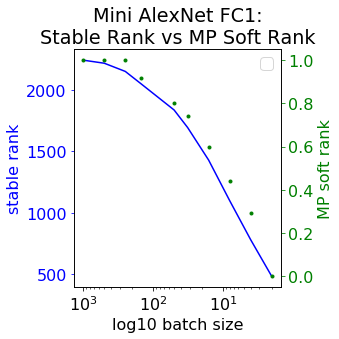

In [14]:
fig, ax1 = plt.subplots()

x = batch_sizes
ax1.invert_xaxis()
#ax1.invert_yaxis()
ax1.set_xscale('log')
ax1.plot(x, stable_ranks, 'b-')

ax1.set_xlabel('log10 batch size')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('stable rank', color='b')
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax2.set_xscale('log')
ax2.plot(x, soft_ranks, 'g.')
ax2.set_ylabel('MP soft rank', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.title("Mini AlexNet FC1:\nStable Rank vs MP Soft Rank")

#plt.text(5, soft_ranks[0], "  2", fontsize=12)
#plt.text(10, soft_ranks[1], "  4", fontsize=12)
#plt.text(8-4, soft_ranks[2], "  8", fontsize=12)
#plt.text(16-10, soft_ranks[3], "  16", fontsize=12)
#plt.text(32-20, soft_ranks[4], "  32", fontsize=12)
#plt.text(64-45, soft_ranks[5], "  50", fontsize=12)
#plt.text(100-60, soft_ranks[6], "  150", fontsize=12)
#plt.text(250-180, soft_ranks[7], "  250", fontsize=12)
#plt.text(500-50, soft_ranks[8], "  500", fontsize=12)
plt.legend()
plt.tight_layout()

plt.savefig(SOFTRANK_FILENAME_FC1)
print("saved file {}".format(SOFTRANK_FILENAME_FC1))

In [15]:
batch_sizes[0:8]

[2, 4, 8, 16, 32, 50, 150, 250]

No handles with labels found to put in legend.


saved file img/mini-alexnet-softrank-sec3.png


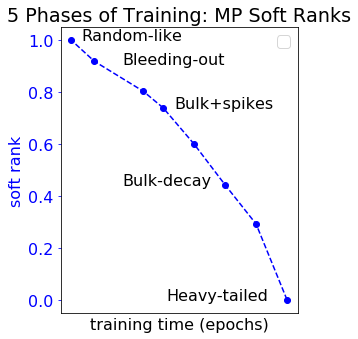

In [16]:
fig, ax1 = plt.subplots()

x = batch_sizes[0:8]
ax1.plot(x, soft_ranks[0:8], linestyle='--', marker='o', color='b')
ax1.set_xscale('log')
ax1.invert_xaxis()
ax1.set_xlabel('training time (epochs)')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('soft rank', color='b')
ax1.tick_params('y', colors='b')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

fig.tight_layout()
plt.title("5 Phases of Training: MP Soft Ranks")

plt.text(200, soft_ranks[8],"Random-like",fontsize=16)
plt.text(80, soft_ranks[6]-0.01,"Bleeding-out",fontsize=16)
plt.text(25, soft_ranks[4],"Bulk+spikes",fontsize=16)

plt.text(80, soft_ranks[2],"Bulk-decay",fontsize=16)
plt.text(30, soft_ranks[0],"Heavy-tailed",fontsize=16)
plt.legend()
plt.tight_layout()

plt.savefig(SOFTRANK_SEC3_FILENAME)
print("saved file {}".format(SOFTRANK_SEC3_FILENAME))

In [17]:
batch_size = 2
eigenvalues = ensemble_evals(batch_size)

saved figure img/mini-alexnet-fc1-bs2.png


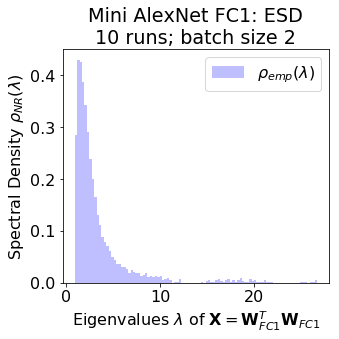

In [18]:

RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q7, num_spikes=0, alpha=ALPHA, skip=True)


plt.title(TITLE_FC1.format(batch_size))
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

filename=FC1_FILENAME.format(batch_size)
plt.savefig(filename)
print("saved figure {}".format(filename))



saved figure img/phase5-heavy-tailed.png


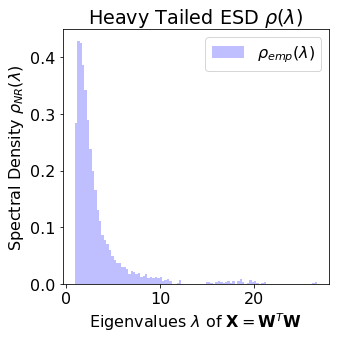

In [19]:
#plt.hist(eigenvalues,bins=100,density=True, color='blue', alpha=ALPHA);
RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q7, num_spikes=0, alpha=ALPHA, skip=True)

plt.title(PHASE_5_TITLE)
plt.xlabel(XLABEL)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

plt.savefig(PHASE_5_FILENAME)
print("saved figure {}".format(PHASE_5_FILENAME))

### Stable Rank

In [20]:
stable_rank = RMT_Util.stable_rank(eigenvalues)
"Stable Rank for batch size 2 {}".format(stable_rank)

'Stable Rank for batch size 2 483.9425048828125'

### Batchsize 4 

In [21]:
batch_size = 4
eigenvalues = ensemble_evals(batch_size)

In [22]:
num_spikes

{2: 0,
 4: 520,
 8: 325,
 16: 175,
 32: 90,
 50: 90,
 100: 75,
 150: 50,
 250: 0,
 500: 0,
 1000: 0}

% spikes outside bulk 13.27
% sigma 1.3869


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs4.png


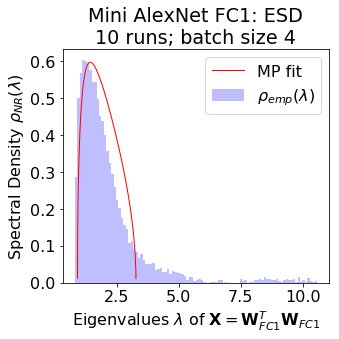

In [23]:
rmt_plot_fc1(batch_size, 450, eigenvalues)

### Batch Size 8

In [24]:
batch_size = 8
eigenvalues = ensemble_evals(batch_size)

% spikes outside bulk 9.25
% sigma 1.2428


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs8.png


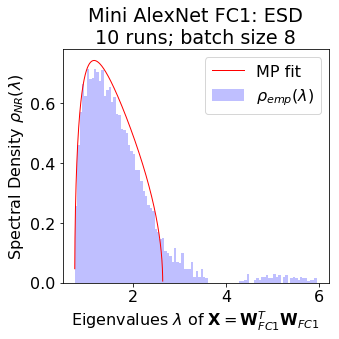

In [25]:
rmt_plot_fc1(batch_size, num_spikes[batch_size], eigenvalues)

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 9.25
% sigma 1.2428
saved figure img/mini-alexnet-fc1-bs8.png


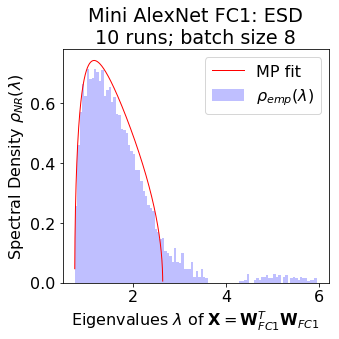

In [26]:
rmt_plot_fc1(batch_size, num_spikes[batch_size], eigenvalues)

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 9.25
% sigma 1.2428
saved file img/phase4-bulk-collapse.png


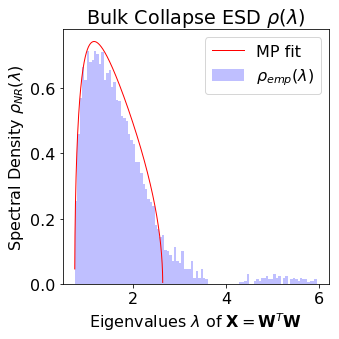

In [27]:
ns = num_spikes[batch_size]
RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q7, num_spikes=ns, alpha=ALPHA)

plt.title(PHASE_4_TITLE)
plt.xlabel(XLABEL)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

plt.savefig(PHASE_4_FILENAME)
print("saved file {}".format(PHASE_4_FILENAME))

### Batch Size 16

In [28]:
batch_size = 16
eigenvalues = ensemble_evals(batch_size)

% spikes outside bulk 4.77
% sigma 1.2059


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs16.png


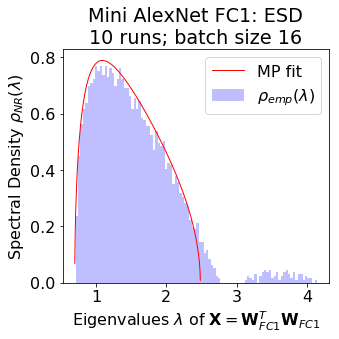

In [29]:
rmt_plot_fc1(batch_size, 175, eigenvalues)

### Batch Size 32

In [30]:
batch_size = 32
eigenvalues = ensemble_evals(batch_size)

% spikes outside bulk 2.40
% sigma 1.2054


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs32.png


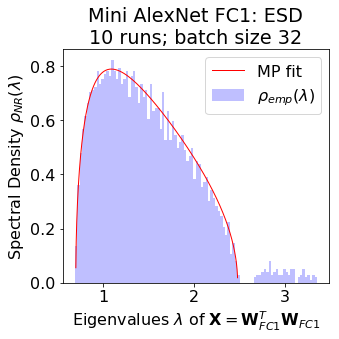

In [31]:
rmt_plot_fc1(batch_size, num_spikes[batch_size], eigenvalues)

### Batch Size 50

In [32]:
batch_size = 50
eigenvalues = ensemble_evals(batch_size)

% spikes outside bulk 2.40
% sigma 1.1996


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs50.png


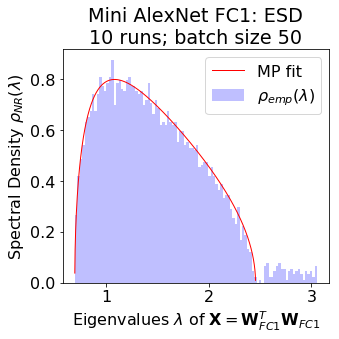

In [33]:
rmt_plot_fc1(batch_size, num_spikes[batch_size], eigenvalues)

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 2.40
% sigma 1.1996
saved file img/phase3-bulk-spikes.png


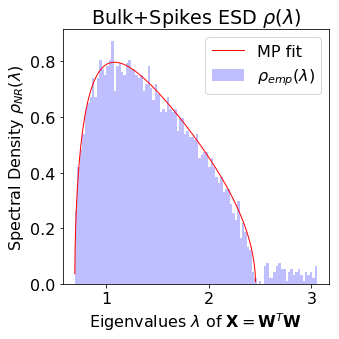

In [34]:
RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q7, num_spikes=num_spikes[batch_size], alpha=ALPHA)
plt.title(PHASE_3_TITLE)
plt.xlabel(XLABEL)
plt.ylabel(YLABEL)
plt.title(PHASE_3_TITLE)
plt.legend()
plt.tight_layout()

print("saved file {}".format(PHASE_3_FILENAME))
plt.savefig(PHASE_3_FILENAME)

### Batch Size 100

In [35]:
batch_size = 100
eigenvalues = ensemble_evals(batch_size)

% spikes outside bulk 1.99
% sigma 1.2013


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs100.png


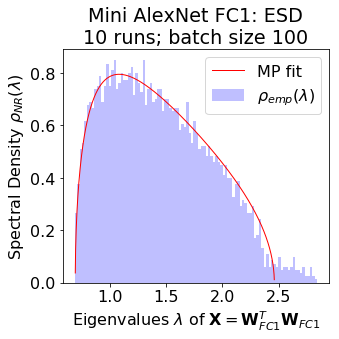

In [36]:
rmt_plot_fc1(batch_size, num_spikes[batch_size], eigenvalues)

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 1.99
% sigma 1.2013
saved file img/phase2-bleeding-out.png


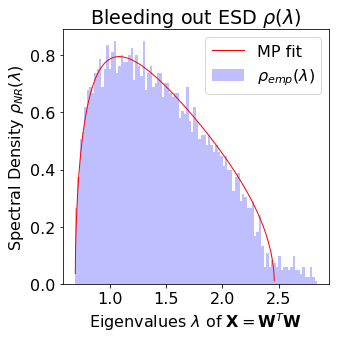

In [37]:
RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q7, num_spikes=num_spikes[batch_size], alpha=ALPHA)
plt.title(PHASE_2_TITLE)
plt.xlabel(XLABEL)
plt.ylabel(YLABEL)
plt.title(PHASE_2_TITLE)
plt.legend()
plt.tight_layout()

print("saved file {}".format(PHASE_2_FILENAME))
plt.savefig(PHASE_2_FILENAME)

### Batch Size 150

In [38]:
batch_size = 150
eigenvalues = ensemble_evals(batch_size)

% spikes outside bulk 1.32
% sigma 1.2054


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs150.png


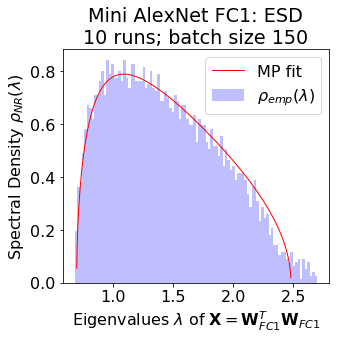

In [39]:
rmt_plot_fc1(batch_size, num_spikes[batch_size], eigenvalues)

### Batch Size 250

In [40]:
batch_size = 250
eigenvalues = ensemble_evals(batch_size)

% spikes outside bulk 0.00
% sigma 1.2239


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs250.png


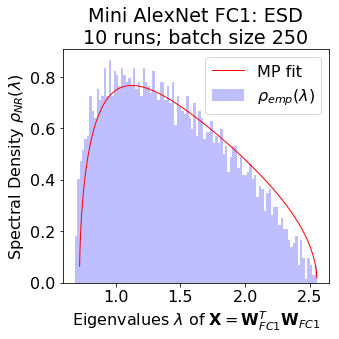

In [41]:
rmt_plot_fc1(batch_size, num_spikes[batch_size], eigenvalues)

### Batch Size 500

In [42]:
batch_size = 500
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC1)

% spikes outside bulk 0.00
% sigma 1.2017


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs500.png


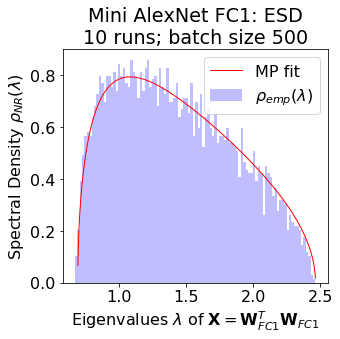

In [43]:
rmt_plot_fc1(batch_size, num_spikes[batch_size], eigenvalues)

###  Batch Size 1000

In [44]:
batch_size = 1000
eigenvalues = ensemble_evals(batch_size)

% spikes outside bulk 0.00
% sigma 1.1929


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc1-bs1000.png


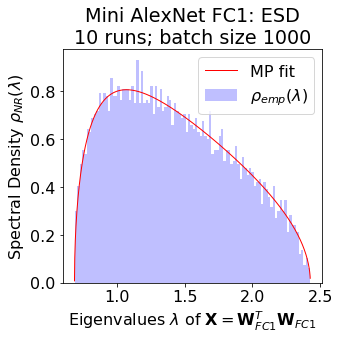

In [45]:
rmt_plot_fc1(batch_size, num_spikes[batch_size], eigenvalues)

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 0.00
% sigma 1.1929
saved file img/phase1-random-like.png


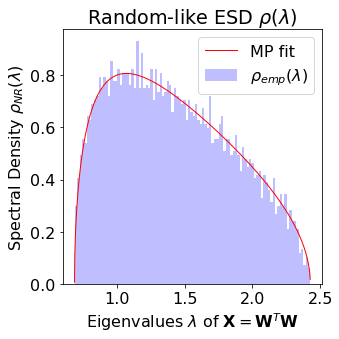

In [46]:
RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q7, num_spikes=0, alpha=ALPHA)
plt.title(PHASE_1_TITLE)
plt.xlabel(XLABEL)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

plt.savefig(PHASE_1_FILENAME)
print("saved file {}".format(PHASE_1_FILENAME))

### FC2 Layer

In [47]:
num_spikes = {2:165, 4:90, 8:90, 16:90, 32:90, 50:90, 100:75, 150:50, 250:0, 500:0, 1000:0} 


% spikes outside bulk 0.00
% sigma 1.0351


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs1000.png


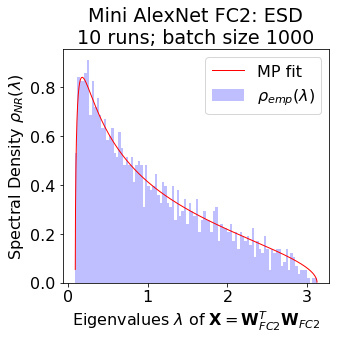

In [48]:
batch_size = 1000
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, num_spikes[batch_size], eigenvalues)


% spikes outside bulk 0.00
% sigma 1.0327


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs500.png


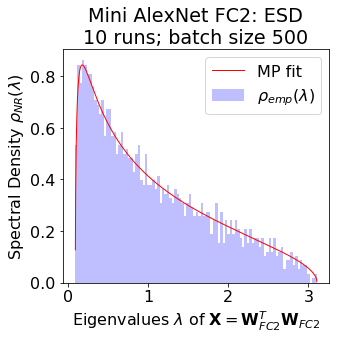

In [49]:
batch_size = 500
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, num_spikes[batch_size], eigenvalues)


% spikes outside bulk 0.00
% sigma 1.0579


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs250.png


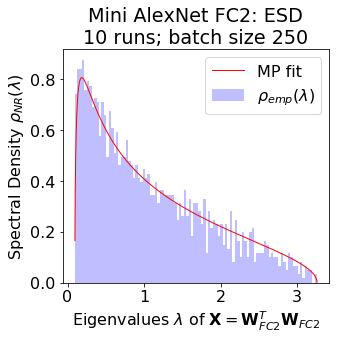

In [50]:
batch_size = 250
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, num_spikes[batch_size], eigenvalues)


% spikes outside bulk 0.00
% sigma 1.0579


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs250.png


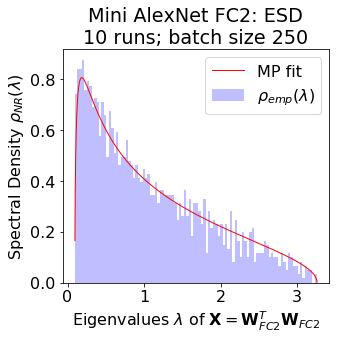

In [51]:
batch_size = 250
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, num_spikes[batch_size], eigenvalues)


% spikes outside bulk 4.07
% sigma 0.9873


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs100.png


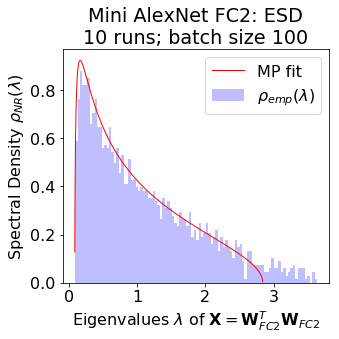

In [52]:
batch_size = 100
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, num_spikes[batch_size], eigenvalues)


% spikes outside bulk 4.92
% sigma 0.9811


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs50.png


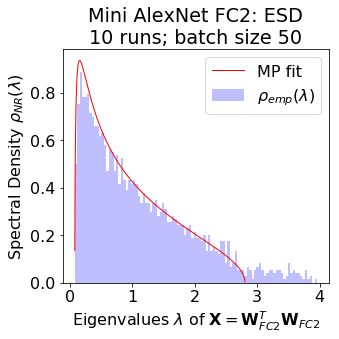

In [53]:
batch_size = 50
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, num_spikes[batch_size], eigenvalues)


% spikes outside bulk 4.92
% sigma 0.9871


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs32.png


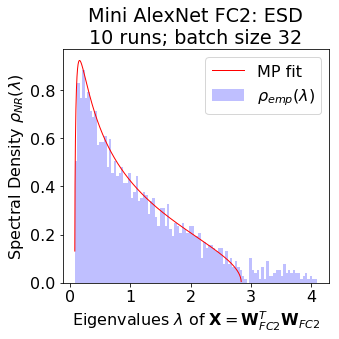

In [54]:
batch_size = 32
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, num_spikes[batch_size], eigenvalues)


% spikes outside bulk 5.03
% sigma 1.0039


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs16.png


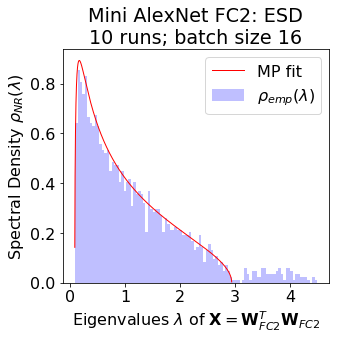

In [55]:
batch_size = 16
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, 92, eigenvalues)


% spikes outside bulk 4.92
% sigma 1.0612


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs8.png


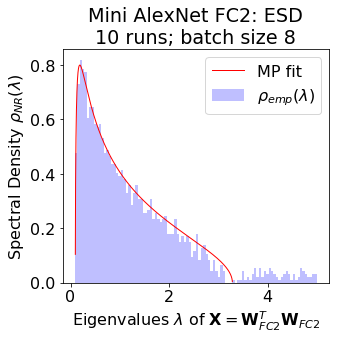

In [56]:
batch_size = 8
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, num_spikes[batch_size], eigenvalues)


% spikes outside bulk 4.92
% sigma 1.1392


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs4.png


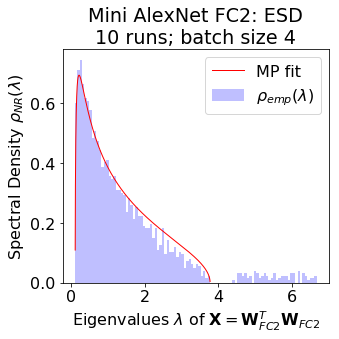

In [57]:
batch_size = 4
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, 90, eigenvalues)


% spikes outside bulk 9.40
% sigma 1.2050


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


saved figure img/mini-alexnet-fc2-bs2.png


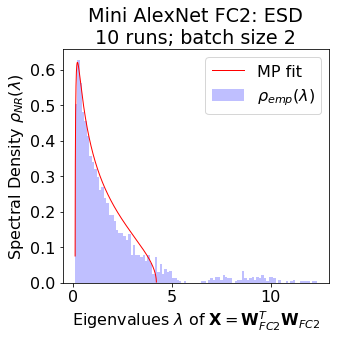

In [58]:
batch_size = 2
eigenvalues = ensemble_evals(batch_size, layer=LAYER_FC2)
rmt_plot_fc2(batch_size, num_spikes[batch_size], eigenvalues)

In [59]:
stable_ranks = []
soft_ranks =  []
for bs in batch_sizes:
    
    ns= num_spikes[bs]        
    evals = ensemble_evals(bs)
    stable_ranks.append(RMT_Util.stable_rank(evals))    
    
    soft_ranks.append(RMT_Util.mp_soft_rank(evals, ns))

No handles with labels found to put in legend.


saved file img/mini-alexnet-softrank-per-batch-fc2.png


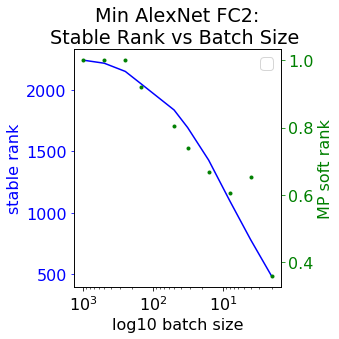

In [60]:
fig, ax1 = plt.subplots()

x = batch_sizes
ax1.invert_xaxis()
#ax1.invert_yaxis()
ax1.set_xscale('log')
ax1.plot(x, stable_ranks, 'b-')

ax1.set_xlabel('log10 batch size')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('stable rank', color='b')
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax2.set_xscale('log')
ax2.plot(x, soft_ranks, 'g.')
ax2.set_ylabel('MP soft rank', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.title("Min AlexNet FC2:\nStable Rank vs Batch Size ")
plt.legend()
plt.tight_layout()

plt.savefig(SOFTRANK_FILENAME_FC2)
print("saved file {}".format(SOFTRANK_FILENAME_FC2))

### Test and Train accuracies, averaged over ~10 batches


In [ ]:
!ls results/*b2.*out

results/cifar10_alexnet.id1.b2.out  results/cifar10_alexnet.id5.b2.out
results/cifar10_alexnet.id10.b2.out results/cifar10_alexnet.id6.b2.out
results/cifar10_alexnet.id2.b2.out  results/cifar10_alexnet.id7.b2.out
results/cifar10_alexnet.id3.b2.out  results/cifar10_alexnet.id8.b2.out
results/cifar10_alexnet.id4.b2.out  results/cifar10_alexnet.id9.b2.out


In [ ]:
outfile_template = "results/cifar10_alexnet.id{}.b{}.out"
train_accs_4_batchsize = {}
test_accs_4_batchsize = {}
for bs in batch_sizes:
    train_accs = []
    test_accs = []

    for i in range(3,10):
        outfile = outfile_template.format(i,bs)
        train_accs.append(RMT_Util.read_training_accuracies(outfile)[-1])
        
        test_accs.append(RMT_Util.read_final_test_accuracy(outfile))

    train_accs_4_batchsize[bs]=np.mean(train_accs)
    test_accs_4_batchsize[bs]=np.mean(test_accs)

In [ ]:
plt.scatter(batch_sizes, train_accs_4_batchsize.values(), color='blue', label='train')
plt.scatter(batch_sizes, test_accs_4_batchsize.values(), color='orange', label='test')
plt.title("Mini AlexNet:\nAccuracies vs Batch Size")
plt.ylabel("Accuracy")
plt.xlabel("log10 Batch Size")
ax = plt.gca()
ax.set_xscale('log')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()


plt.savefig(ACCURACIES_FILENAME)
print("saved file {}".format(ACCURACIES_FILENAME))